In [1]:
import torch
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import time
import json

In [2]:
device = "cpu" # I'm not sure if it will work out of the box with cuda even if you have a GPU
model = models.vgg19(pretrained=True)
full_model = nn.Sequential(model, nn.Softmax(dim=1)).to(device).eval()

# Label Conversion

This step is done because the labels for the validation dataset do not match the labels from the pretrained model. 

In [3]:
PATH = 'labels/imagenet_class_index.json'
with open(PATH, 'r') as fp:
    labels_65 = json.load(fp)

# labels_65 is the default labels from pretrained model
labels_65 = {value[0]: int(key) for key,value in labels_65.items()} 

labels_file = open('labels/labels.txt')
labels_490 = {} #labels_490 is the labels from the validation txt
for line in labels_file:
    contents = line.split()
    val = contents[2]
    key = contents[1]
    n_name = contents[0] 
    labels_490.update({int(key): [n_name,val]})

In [4]:
def Convert_labels_file(k_490):
    n_name = labels_490[k_490][0]
    k_65 = labels_65[n_name]
    
    return k_65

In [5]:
ground_truth_handle = open('labels/ILSVRC2012_validation_ground_truth.txt')

count = 0
num_images = 1000
Converted_labels = []
for line in ground_truth_handle:
    if count == num_images:
        break
    k_65 = Convert_labels_file(int(line))
    Converted_labels.append(k_65)
    
    count+=1

In [6]:
def __fgsm(model, x, label, epsilon, targeted, clamp):
    model.zero_grad()

    x = torch.as_tensor(x, device=device)
    x.requires_grad = True
    
    logits = model(x)
    target = torch.LongTensor([label]).to(device)
    loss = nn.CrossEntropyLoss()(logits, target)
    loss.backward()
    
    diff = epsilon * x.grad.sign()
    
    if targeted:
        adv = x - diff
    else:
        adv = x + diff
    
    return adv.clamp(0, 1) if clamp else adv

def fgsm_targeted(model, x, label, epsilon, clamp=True):
    """
    model = neural network with logits output (not softmax)
    x = image 
    label = target label (don't care about the true label)
    epsilon = distance to move 
    clamp = Limit output values to the range [0,1]
    """
    return __fgsm(model, x, label, epsilon, True, clamp)
    
def fgsm_untargeted(model, x, label, epsilon, clamp=True):    
    """
    model = neural network with logits output (not softmax)
    x = image
    label = the true label
    epsilon = distance to move 
    clamp = Limit output values to the range [0,1]
    """
    return __fgsm(model, x, label, epsilon, False, clamp)

def plotter(image, adverserial, full_model):
    """Show the original (img), adversarial attack (adv), and some more stuff. Pass images as pytorch tensors"""
    image = image.cpu().detach()
    adverserial = adverserial.cpu().detach()
    
    probability_original = full_model(image.to(device)).cpu().detach().numpy()
    origial_image = image.numpy()[0]
    
    probability_adverserial = full_model(adverserial.to(device)).cpu().detach().numpy()
    adverserial_image = adverserial.numpy()[0]
    
    f, axes = plt.subplots(1,3, figsize=(15, 6))
    
    ax = axes[0]
    prediction = probability_original.argmax()
    ax.set_title("Original, class: {} ({:.0f} %): '{}'".format(
        prediction, 100*probability_original[0, prediction], labels[prediction])
    )
    ax.imshow(np.transpose(origial_image, (1,2,0)))
    
    ax = axes[1]
    prediction = probability_adverserial.argmax()
    ax.set_title("Adverserial, class: {} ({:.0f} %): '{}'".format(
        prediction, 100*probability_adverserial[0, prediction], labels[prediction])
    )
    ax.imshow(np.transpose(adverserial_image, (1,2,0)))
    
    ax = axes[2]
    diff = np.transpose(adverserial_image - origial_image, (1,2,0))
    plt.imshow(diff + 0.5)
    plt.show()

## Attack 100 validation images

Note: This will take some time.

In [13]:
min_img_size = 224 
fro = 150
imgs =  100 # Choose number of images you want to check
epsilons = [0.01, 0.05, 0.10, 0.20, 0.30]
adv_accuracies = []

for epsilon in epsilons:
    
    original_correct = 0
    adv_correct = 0
    cls = {}
    
    for i in range(fro,fro+imgs):
        if(i<10):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' +'00' +str(i) 
        elif(i<100):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' +'0' +str(i)
        elif(i<1000):
            directory_imgs = 'ILSVRC2012_img_val/ILSVRC2012_val_00000' + str(i)
        filename = directory_imgs 
        img = Image.open(directory_imgs+'.JPEG')

        # Transformation of image
        pre_transform = transforms.Compose([transforms.Resize((min_img_size,min_img_size)), transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ])
        image_tensor = pre_transform(img)
        image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W
        img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable

        # Classification
        output = model.forward(img_variable)
        original_class = torch.max(output.data, 1)[1][0]  #get an index(class number) of a largest element
        original_class = original_class.item()
        cls.update({i:original_class})

        # Adversarial attack
        adv = fgsm_untargeted(model, image_tensor, label=original_class, epsilon = epsilon, clamp=True)
        adv = adv.cpu().detach()
        probability_adverserial = full_model(adv.to(device)).cpu().detach().numpy()
        adverserial_image = adv.numpy()[0]
        prediction = probability_adverserial.argmax()

        # Computing Accuracies
        if(original_class == Converted_labels[i-1]):
            original_correct+=1
        if(prediction == Converted_labels[i-1]):
            adv_correct+=1

        print(i,Converted_labels[i-1],original_class, prediction)


    original_correct = original_correct/imgs*100 
    adv_correct = adv_correct/imgs*100
    print('Original_Accuracy: '+ str(original_correct) + ' %' )
    print('Adversarial_Accuracy: '+ str(adv_correct) + str(' %'))
    
    adv_accuracies.append(adv_correct)

150 975 977 978
151 620 922 611
152 637 637 730
153 39 39 47
154 115 115 107
155 937 937 111
156 272 274 980
157 277 277 5
158 763 763 763
159 789 905 765
160 646 646 646
161 213 214 980
162 493 894 799
163 647 647 438
164 504 504 504
165 937 937 973
166 687 687 716
167 781 781 922
168 666 666 659
169 583 583 583
170 158 158 107
171 825 825 825
172 212 212 251
173 659 659 659
174 257 257 222
175 436 436 436
176 196 199 110
177 140 140 6
178 248 250 282
179 339 339 921
180 230 230 6
181 361 731 862
182 544 926 868
183 935 935 961
184 638 445 921
185 627 656 656
186 289 289 815
187 867 867 908
188 272 272 353
189 103 979 111
190 584 823 892
191 180 179 921
192 703 448 693
193 449 449 510
194 771 771 446
195 118 118 121
196 396 396 396
197 934 922 549
198 16 16 989
199 548 548 556
200 993 993 973
201 704 704 438
202 457 823 411
203 233 233 295
204 401 543 549
205 827 482 605
206 376 376 4
207 146 85 815
208 606 606 662
209 922 922 782
210 516 431 793
211 284 284 264
212 889 889 921
213 47

In [15]:
Accuracies = [66, 14.000000000000002, 14.000000000000002, 9.0, 4.0, 3.0]

In [17]:
epsilons.insert(0,0)

In [19]:
adv_accuracies.insert(0,66)

[66, 14.000000000000002, 14.000000000000002, 9.0, 4.0, 3.0]


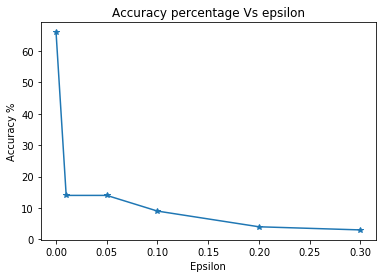

In [22]:
plt.plot(epsilons, adv_accuracies, '*-')
plt.title("Accuracy percentage Vs epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy %")
plt.show()